1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [15]:
import pandas as pd 
import numpy as np

N = 20000
df = pd.read_csv('data/data_000637.txt', nrows = N)
display(df)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29
19996,1,0,63,3869200366,2517,6
19997,1,0,32,3869200366,2519,5
19998,1,0,17,3869200366,2522,21


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [16]:
max_bx = df['BX_COUNTER'].max() + 1
print("estimation number: ", max_bx)

estimation number:  3564


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [17]:
initial_ns = (min(df["ORBIT_CNT"]) * max_bx + min(bx_with_min_orbit["BX_COUNTER"])) * 25 + min(tdc_with_min_bx["TDC_MEAS"]) * 25/30                                                                                                 
df['NS_PASSED'] = ((df['ORBIT_CNT'] * max_bx + df['BX_COUNTER']) * 25 + df['TDC_MEAS'] * 25 / 30) - initial_ns
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NS_PASSED
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29,1.773438e+07
19996,1,0,63,3869200366,2517,6,1.773446e+07
19997,1,0,32,3869200366,2519,5,1.773451e+07
19998,1,0,17,3869200366,2522,21,1.773460e+07


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [8]:
#and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS')

max_tdc = max(df["TDC_MEAS"]) + 1

dif_orbit = max(df["ORBIT_CNT"]) - min(df["ORBIT_CNT"])

bx_with_max_orbit = df.loc[df['ORBIT_CNT'] == max(df["ORBIT_CNT"])]
bx_with_min_orbit = df.loc[df['ORBIT_CNT'] == min(df["ORBIT_CNT"])]

dif_bx = max(bx_with_max_orbit["BX_COUNTER"]) - min(bx_with_min_orbit["BX_COUNTER"])

tdc_with_max_bx = bx_with_max_orbit.loc[bx_with_max_orbit['BX_COUNTER'] == max(bx_with_max_orbit["BX_COUNTER"])]
tdc_with_min_bx = bx_with_min_orbit.loc[bx_with_min_orbit['BX_COUNTER'] == min(bx_with_min_orbit["BX_COUNTER"])]

dif_tdc = max(tdc_with_max_bx["TDC_MEAS"]) - min(tdc_with_min_bx["TDC_MEAS"])

if(dif_tdc < 0):
    dif_bx = dif_bx - 1
    dif_tdc = dif_tdc + max_tdc

print(dif_orbit, " orbit ")
print(dif_bx, " bx")
print(dif_tdc, " tdc")

print(((dif_orbit*max_bx)+dif_bx)*25*1e-9 + dif_tdc * 25/30*1e-9, " seconds")

8844  orbit 
313  bx
29  tdc
0.7880082491666667  seconds


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [10]:
noisy_channels = df.groupby(by=["TDC_CHANNEL"]).size().sort_values(ascending = False).head(3)
noisy_channels

TDC_CHANNEL
139    82677
64     50201
63     49335
dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [11]:
non_empty_orbits = df.groupby('ORBIT_CNT')
print("Number of non-empty orbits: ", len(non_empty_orbits))

Number of non-empty orbits:  8841


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [12]:
tdc_channel_139 = df[df['TDC_CHANNEL'] == 139].groupby('ORBIT_CNT')
print("Number of unique orbits where TDC_CHANNEL is equal to 139: ", len(tdc_channel_139))

Number of unique orbits where TDC_CHANNEL is equal to 139:  8816


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

<AxesSubplot:title={'center':'FPGA 1'}, xlabel='TDC_CHANNEL'>

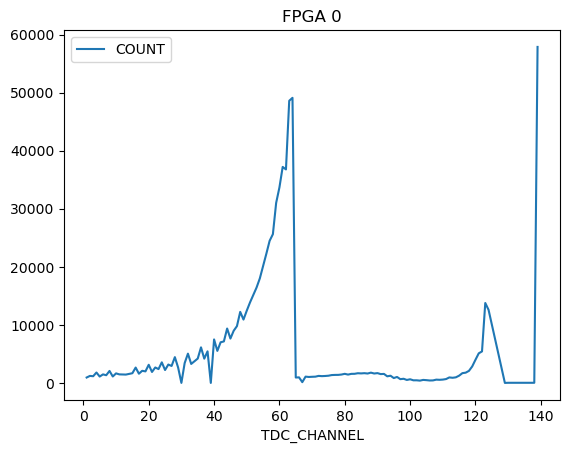

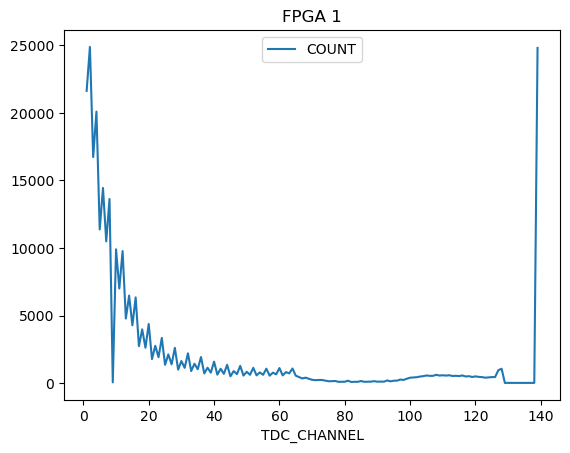

In [14]:
# two occupancy plots one for each FPGA (0,1)
fpga_0 = df[df['FPGA']== 0].groupby('TDC_CHANNEL').size().reset_index(name='COUNT')
fpga_0.plot(x = 'TDC_CHANNEL', y = 'COUNT', title = "FPGA 0")

fpga_1 = df[df['FPGA']== 1].groupby('TDC_CHANNEL').size().reset_index(name='COUNT')
fpga_1.plot(x = 'TDC_CHANNEL', y = 'COUNT', title = "FPGA 1")

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.